# lossのlandscapeの可視化方法

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# 例として、シンプルなMLPを作成
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# 2. データセットの作成
torch.manual_seed(0)
X = torch.randn(500, 2)
y = X.sum(dim=1, keepdim=True)  # シンプルな線形和をターゲット

# 3. モデルの学習
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習ループ
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

# 4. モデルを保存
model_path = "./simple_nn.pth"
torch.save(model.state_dict(), model_path)


In [5]:
# 5. 学習済みモデルをロード
model = SimpleNN()
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleNN(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
# 6. 重み空間の2D方向を定義
params = [p for p in model.parameters()]
params_vector = torch.cat([p.view(-1) for p in params])

torch.Size([65])

In [8]:
# ランダムな方向を2つ選択
torch.manual_seed(0)
direction_1 = torch.randn_like(params_vector)
direction_2 = torch.randn_like(params_vector)

# 正規化
direction_1 /= torch.norm(direction_1)
direction_2 /= torch.norm(direction_2)

In [9]:
# 7. Loss Landscape の計算
alphas = np.linspace(-1, 1, 30)
betas = np.linspace(-1, 1, 30)
loss_values = np.zeros((len(alphas), len(betas)))

for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        # パラメータを変更
        new_params = params_vector + alpha * direction_1 + beta * direction_2
        index = 0
        with torch.no_grad():
            for p in model.parameters():
                num_params = p.numel()
                p.copy_(new_params[index:index+num_params].view(p.size()))
                index += num_params

        # 損失を計算
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss_values[i, j] = loss.item()

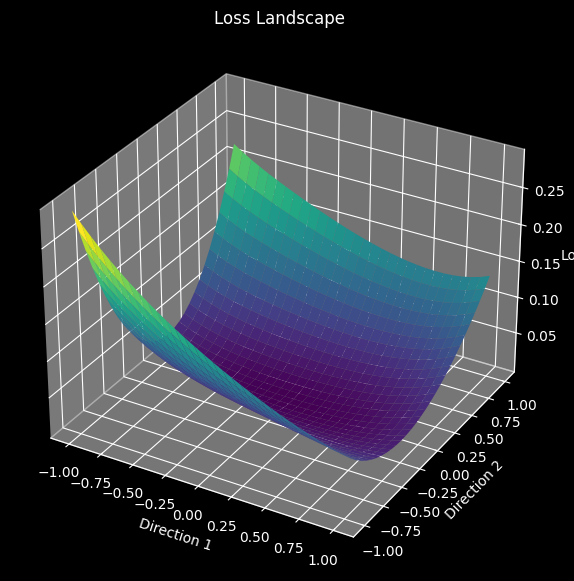

In [11]:
# 8. 3Dプロットの作成
X_grid, Y_grid = np.meshgrid(alphas, betas)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_grid, Y_grid, loss_values, cmap='viridis')

ax.set_xlabel('Direction 1')
ax.set_ylabel('Direction 2')
ax.set_zlabel('Loss')
ax.set_title('Loss Landscape')
plt.show()